In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
import os
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as tt
import torch.backends.cudnn as cudnn


import pickle

from tqdm import tqdm

from torchinfo import summary



from models import ResNet18

import time




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# model = ResNet18(3, 10)
model = models.resnet18(weights=None)
num_classes = 10
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

num_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")



Number of trainable parameters: 11,181,642


In [41]:
def calculate_mean_std(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean_sum = torch.zeros(3)
    std_sum = torch.zeros(3)
    num_batches = 0

    for images, _ in dataloader:
        num_batches += 1
        for i in range(3):
            mean_sum[i] += images[:,i,:,:].mean()
            std_sum[i] += images[:,i,:,:].std()

    mean = mean_sum / num_batches
    std = std_sum / num_batches

    return mean, std


# Path for the dataset and the mean/std file
data_path = '../data'
mean_std_file = os.path.join(data_path, 'cifar10_mean_std.pkl')


# Check if mean/std file exists, calculate if not
if not os.path.exists(mean_std_file):
    # Load CIFAR-10 without normalization
    trainset_raw = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=tt.ToTensor())
    mean, std = calculate_mean_std(trainset_raw)
    with open(mean_std_file, 'wb') as f:
        pickle.dump((mean, std), f)
    print("Mean and Std Dev calculated and saved.")
else:
    with open(mean_std_file, 'rb') as f:
        mean, std = pickle.load(f)
    print("Mean and Std Dev loaded from file.")

print(f"Mean: {mean}, Std: {std}")

transform_train = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 

                         tt.RandomRotation(degrees=(0, 90)),
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomPerspective(distortion_scale=0.14),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                         tt.ToTensor(), 
                         tt.Normalize(mean, std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])



Mean and Std Dev loaded from file.
Mean: tensor([0.4915, 0.4822, 0.4466]), Std: tensor([0.2463, 0.2428, 0.2607])


In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print(f"Using device: {device}")


Using device: cuda


In [44]:
batch_size=400

# Load the CIFAR-10 dataset with transforms
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2*batch_size, shuffle=False, num_workers=3,pin_memory=True)





Files already downloaded and verified
Files already downloaded and verified


In [45]:
# Move data and model to device
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)
model = to_device(model, device)


In [46]:
epochs = 100
max_lr = 0.001
grad_clip = 0.75
bias_clip= True
weight_decay = 0.0001
betas=(0.9,0.95)

In [47]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr,weight_decay=weight_decay,fused=True, betas=betas)
optimizer = PAdam(model.parameters(), lr=max_lr, lambda_p=1e-5, p_norm=0.8)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001,weight_decay=1e-4,momentum=0.9)
# decay_rate = 10 ** (-2 / epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 1563,# Number of iterations for the first restart (Total iterations are epochs*len(train_loader) then divide that by how many times you want a restart)
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate


In [ ]:
# model = torch.compile(model) # requires PyTorch 2.0



best_accuracy = 0.0
iteration_count = 0
train_losses = []
val_losses = []
accuracies = []
lrs = []

start_time = time.time()    
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for data in trainloader:
        iteration_count += 1
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item()
        scheduler.step()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            



    avg_val_loss = running_val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
        }, '../data/best_model.pth')  # Update path as needed

    # Calculate and format runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * epochs / (epoch + 1)
    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    # Track and store current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

    status_message = f"Epoch: {epoch+1}/{epochs}\titer: {iteration_count}\tTrain Loss: {avg_train_loss:.4f}\tTest Loss: {avg_val_loss:.4f}\tAccuracy: {accuracy:.2f}%\tCurrent LR: {current_lr:.5f}\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}"
    print(f"\r{status_message}",end='')

print()
print('Finished Training')

Epoch: 88/100	iter: 11000	Train Loss: 0.7104	Test Loss: 0.7516	Accuracy: 74.24%	Current LR: 0.00100	Elapsed Time: 00:25:43	Expected Time: 00:29:13

In [14]:
print(lrs)

[0.0009998310263493043, 0.000999271251071315, 0.0009983201174890326, 0.0009969783786991124, 0.0009952470970749304, 0.0009931276434254083, 0.0009906216959096228, 0.0009877312387080585, 0.0009844585604515557, 0.000980806252409201, 0.0009767772064365882, 0.0009723746126860803, 0.0009676019570808845, 0.0009624630185549374, 0.0009569618660607892, 0.0009511028553478527, 0.0009448906255135718, 0.0009383300953302373, 0.000931426459350359, 0.000924185183793679, 0.0009166120022190815, 0.0009087129109848266, 0.000900494164500703, 0.0008919622702758575, 0.0008831239837662245, 0.0008739863030256334, 0.0008645564631648298, 0.0008548419306227973, 0.0008448503972549182, 0.000834589774242649, 0.0008240681858295391, 0.0008132939628885472, 0.0008022756363257518, 0.0007910219303256783, 0.0007795417554435886, 0.0007678442015502066, 0.0007559385306344632, 0.0007438341694699585, 0.000731540702150952, 0.0007190678625037855, 0.0007064255263797525, 0.000693623703835511, 0.0006806725312072366, 0.0006675822630847

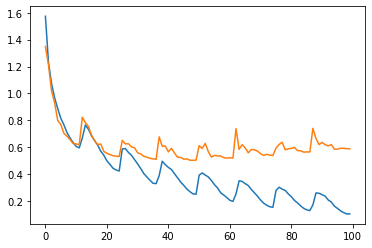

In [36]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()